In [48]:
!pip install -q langchain langgraph langchain-groq chromadb requests beautifulsoup4 feedparser python-dotenv

In [49]:
import os
import json
from typing import TypedDict, List, Dict, Any, Optional

import requests
import feedparser
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.tools import tool
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, END
from IPython.display import display, Image


groq_api_key = "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"
MODEL_NAME = "llama-3.3-70b-versatile"


In [57]:
# AGENT's TOOLS (Weather, News, Planner)

@tool
def WeatherTool(location: str) -> str:
    """Get the current weather and a forecast for a location using the Open-Meteo API."""
    print(f"--- Calling WeatherTool for: {location} ")
    try:
        geo_r = requests.get("https://geocoding-api.open-meteo.com/v1/search", params={"name": location, "count": 1})
        geo_r.raise_for_status()
        geo_res = geo_r.json().get("results")
        if not geo_res:
            return json.dumps({"ok": False, "error": f"Could not find coordinates for '{location}'."})
        coords = {"lat": geo_res[0]["latitude"], "lon": geo_res[0]["longitude"]}

        params = {"latitude": coords["lat"], "longitude": coords["lon"], "current": "temperature_2m,weather_code", "hourly": "precipitation_probability", "timezone": "auto"}
        weather_r = requests.get("https://api.open-meteo.com/v1/forecast", params=params)
        weather_r.raise_for_status()
        return json.dumps({"ok": True, "data": weather_r.json()})
    except Exception as e:
        return json.dumps({"ok": False, "error": str(e)})

@tool
def NewsTool(location: str) -> str:
    """Get the top 3 local news headlines for a location using the Google News RSS feed."""
    print(f"--- Calling NewsTool for: {location} ")
    try:
        rss_url = f"https://news.google.com/rss/search?q={requests.utils.quote(location)}&hl=en&gl=US&ceid=US:en"
        feed = feedparser.parse(rss_url)
        titles = [entry.title for entry in feed.entries[:3]]
        if not titles: return json.dumps({"ok": False, "error": "No headlines found."})
        return json.dumps({"ok": True, "headlines": titles})
    except Exception as e:
        return json.dumps({"ok": False, "error": str(e)})

@tool
def PlannerTool(context_json: str) -> str:
    """
    Generates the final daily plan as a JSON object based on the provided context.
    This tool has a rule-based fallback if the LLM fails, ensuring reliability.
    """
    print(f"--- Calling PlannerTool to generate the final plan ")
    context = json.loads(context_json)
    try:
        sys_prompt = (
            "You are DayMate, a concise daily planning assistant. "
            "Given JSON context, produce a final JSON object with keys: 'location', 'weather_summary', 'news', and 'plan'. "
            "Your 'plan' should be a short, actionable paragraph that directly addresses the user's preferences, "
            "factoring in the weather and news. Respond ONLY with the JSON object, nothing else."
        )
        messages = [SystemMessage(content=sys_prompt), HumanMessage(content=f"Context:\n```json\n{json.dumps(context, indent=2)}\n```")]
        resp = LLM.invoke(messages)
        text = resp.content.strip().replace("```json\n", "").replace("```", "")
        result = json.loads(text)
        return json.dumps({"ok": True, "result": result})

    except Exception as e:
        print(f"PlannerTool LLM failed: {e}. Using rule-based fallback.")
        weather_data = context.get("weather_info", {}).get("data", {})
        news = context.get("news_info", {}).get("headlines", [])
        plan_suggestions = []
        if weather_data:
            temp = weather_data.get("current", {}).get("temperature_2m", "N/A")
            weather_summary = f"Current temperature is {temp}°C."
            precip_chances = weather_data.get("hourly", {}).get("precipitation_probability", [])
            if any(chance > 40 for chance in precip_chances[16:22]): # Check evening hours
                plan_suggestions.append("There's a chance of rain this evening, so an umbrella is a good idea.")
        else: weather_summary = "Weather data unavailable."
        if news: plan_suggestions.append(f"Be aware of local events: {news[0]}")

        fallback_plan = {
            "location": context.get("location", "N/A"),
            "weather_summary": weather_summary,
            "news": news,
            "plan": " ".join(plan_suggestions) if plan_suggestions else "Have a great day! Check local conditions before heading out."
        }
        return json.dumps({"ok": True, "result": fallback_plan, "note": "Used rule-based fallback."})


In [58]:
# DEFINE THE LANGGRAPH WORKFLOW

class AgentState(TypedDict):
    location: str
    preferences: str
    weather_info: Optional[Dict[str, Any]]
    news_info: Optional[Dict[str, Any]]
    final_plan: Optional[Dict[str, Any]]

def gather_info(state: AgentState):
    """First step: Call WeatherTool and NewsTool to gather information."""
    location = state["location"]
    weather_json = WeatherTool.invoke({"location": location})
    news_json = NewsTool.invoke({"location": location})
    return {"weather_info": json.loads(weather_json), "news_info": json.loads(news_json)}

def generate_plan(state: AgentState):
    """Second step: Assemble context and call PlannerTool to create the final output."""
    context = {"location": state["location"], "preferences": state["preferences"], "weather_info": state["weather_info"], "news_info": state["news_info"]}
    plan_json = PlannerTool.invoke({"context_json": json.dumps(context)})
    return {"final_plan": json.loads(plan_json)}

# Build the Graph
workflow = StateGraph(AgentState)
workflow.add_node("gather_info", gather_info)
workflow.add_node("generate_plan", generate_plan)
workflow.set_entry_point("gather_info")
workflow.add_edge("gather_info", "generate_plan")
workflow.add_edge("generate_plan", END)
day_mate_agent = workflow.compile()

In [59]:

# CONVERSATIONAL HANDLER

class DayMateSession:
    def __init__(self):
        self.last_location: Optional[str] = None

    def extract_inputs_from_query(self, query: str) -> Dict[str, Optional[str]]:
        """Uses the LLM to extract 'location' and 'preferences' from a natural language query."""
        print("--- Extracting details from user query ---")
        sys_prompt = (
            "Extract 'location' and 'preferences' from the user's message. "
            "The location is the city or place they mention. "
            "Preferences are what they plan to do. "
            "Respond ONLY with a JSON object like {\"location\": \"...\", \"preferences\": \"...\"}. "
            "If a value is missing, set it to null."
        )
        messages = [SystemMessage(content=sys_prompt), HumanMessage(content=query)]
        try:
            resp = LLM.invoke(messages)
            text = resp.content.strip().replace("```json\n", "").replace("```", "")
            return json.loads(text)
        except Exception:
            return {"location": None, "preferences": query} # Fallback on failure

    def run(self, user_query: str) -> Dict[str, Any]:
        """Handles a single turn of the conversation."""
        extracted = self.extract_inputs_from_query(user_query)
        location = extracted.get("location") or self.last_location
        preferences = extracted.get("preferences") or ""

        if not location:
            return {"plan": "I can help with that! Please tell me your city first."}

        # Run the deterministic LangGraph agent to get the plan
        initial_state = {"location": location, "preferences": preferences}
        final_state = day_mate_agent.invoke(initial_state)

        # Remember the location for the next turn in the conversation
        self.last_location = location

        plan_data = final_state.get("final_plan", {})
        if plan_data.get("ok"):
            final_result = plan_data["result"]
            # Ensure the output format matches the assignment's example output
            if "weather_summary" in final_result:
                final_result["weather"] = final_result.pop("weather_summary")
            return final_result
        else:
            return {"error": "Sorry, I couldn't generate a plan.", "details": plan_data}



Agent Graph Structure:


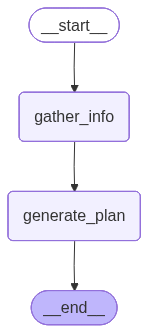

In [60]:

# VISUALIZE THE AGENT'S GRAPH

try:
    graph_image = day_mate_agent.get_graph().draw_mermaid_png()
    print("\nAgent Graph Structure:")
    display(Image(graph_image))
except Exception as e:
    print(f"\nCould not draw graph. To see it, you may need to install 'pygraphviz'. Error: {e}")


In [61]:

# CHAT SESSION

print("DayMate is ready! Type your request, or 'bye' to exit.")
print("="*80)

session = DayMateSession()

# Run an example query first
first_query = "Hey DayMate, I’m in Dhaka today and want to go out in the evening."
print(f"\nYou: {first_query}")
reply = session.run(first_query)
print("\nDayMate:")
print(json.dumps(reply, indent=2))

# Start the continuous interactive loop
while True:
    try:
        user_text = input("\nYou: ").strip()
        if user_text.lower() in ["bye", "exit", "quit"]:
            print("\nDayMate: Goodbye!")
            break
        if not user_text:
            continue

        reply = session.run(user_text)
        print("\nDayMate:")
        print(json.dumps(reply, indent=2))

    except (KeyboardInterrupt, EOFError):
        print("\nDayMate: Goodbye!")
        break

DayMate is ready! Type your request, or 'bye' to exit.

You: Hey DayMate, I’m in Dhaka today and want to go out in the evening.
--- Extracting details from user query ---
--- Calling WeatherTool for: Dhaka 
--- Calling NewsTool for: Dhaka 
--- Calling PlannerTool to generate the final plan 

DayMate:
{
  "location": "Dhaka",
  "news": "A factory fire in Dhaka has resulted in at least 16 deaths, with the toll potentially rising",
  "plan": "Given the partly cloudy weather, consider going out in the evening as planned, but be aware of the current situation in Dhaka due to the factory fire and take necessary precautions to ensure your safety.",
  "weather": "Partly cloudy with a temperature of 28\u00b0C"
}

DayMate: Goodbye!
